# The aim of this notebook is to create a model that predicts the size of a wildfire

Author: Marcelo Garcia Escalante

## Index

1. [EDA+Preprocess Data](#1.-EDA-(Exploratory-Data-Analysis)-+-preprocess-data)
 * [Clean data](#Clean-data)
     * [Parsing Dates](#Parsing-Dates)
     * [Find null values](#Find-null-values)
     * [fillining null data](#fillining-null-data)
 * [Feature engineering](#Feature-engineering)
 * [Standardize data](#Standardize-data)
 * [Visualize class distribution](#Visualize-class-distribution)
 
2. [Build Model](#2.-Build-Model)
 * [One Hot encode categorical data](#One-Hot-encode-categorical-data)
 * [Stratified cross validation](#Stratified-cross-validation)
 * [Define feature importance](#Define-feature-importance)
3. [Make submission](#3.-Make-submission)
4. [References](#4.-References)

In [2910]:
# All imports for the project goes here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from helpers import feature_plot, oneHotEnc_to_classes, parse_datetime_features_to_hours, RocCallback
from helpers import datetime_feature_engineering, fill_datetime_with_neighbors, fire_number_feature_engineering
from helpers import F1Callback
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import category_encoders as ce
from datetime import datetime
from sklearn.preprocessing import StandardScaler, RobustScaler
from helpers import feature_plot
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. EDA (Exploratory Data Analysis) + preprocess data

In this section, we will visualize and analyze our dataset. Also any possible clean-up required will be performed. 

In [4803]:
# Loading the dataset
#train = pd.read_csv('train_fuel_plus_true_cause_plus_activity_class.csv')
#test = pd.read_csv('test_fuel_plus_true_cause_plus_activity_class.csv')
#train = pd.read_csv(
#    'train_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope_pp_fire_type2.csv')
#test = pd.read_csv(
#    'test_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope_pp_fire_type2.csv')

train = pd.read_csv(
    'train_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope_pp_fire_type2.csv')
test = pd.read_csv(
    'test_fuel_pp_true_cause_pp_activity_class_pp_weather_conditions_pp_fire_posSlope_pp_fire_type2.csv')

In [4804]:
train.dtypes

fire_number                      object
fire_year                         int64
assessment_datetime              object
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
reported_date                    object
start_for_fire_date              object
fire_fighting_start_date         object
initial_action_by                object
fire_type                        object
fire_position_on_slope           object
weather_conditions_over_fire     object
fuel_type                        object
bh_fs_date                       object
uc_fs_date                       object
ex_fs_date                       object


`note:` We can see that most of our data is categorical with two of the features being float numbers and one an integer

In [4805]:
#Visualizing the train dataset
train.tail()

,fire_number,fire_year,assessment_datetime,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,fire_start_date,det_agent_type,det_agent,discovered_date,reported_date,start_for_fire_date,fire_fighting_start_date,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_fs_date,uc_fs_date,ex_fs_date
15870,SWF001,2006,2006-04-07 17:55:00,B,55.355664,-115.776846,Indian Reservation,Incendiary,Lighting Fires,Arson Known,2006-04-07 16:46:00,UNP,LFS,2006-04-07 17:46:00,2006-04-07 17:46:00,2006-04-07 18:00:00,NaN,Fire Department,Surface,Flat,Clear,O1a,2006-04-07 17:55:00,2006-04-07 17:55:00,2006-04-07 19:30:00
15871,HWF091,2008,2008-06-03 15:35:00,A,58.743900,-117.223467,Provincial Land,Lightning,Heavy Equipment,Unpredictable Event,2008-06-02 19:00:00,UNP,UPA,2008-06-03 15:00:00,2008-06-03 15:03:00,2008-06-03 15:08:00,2008-06-03 16:00:00,HAC1F,Ground,Flat,Clear,C2,2008-06-03 16:42:00,2008-06-03 16:42:00,2008-06-03 18:24:00
15872,HWF234,2015,2015-06-26 15:27:00,E,59.846600,-116.768133,Provincial Land,Lightning,Debris Disposal,Unsafe Fire,2015-06-26 12:00:00,UNP,UPA,NaN,2015-06-26 15:27:00,2015-06-26 17:30:00,2015-06-26 17:30:00,FTAC,Ground,Flat,CB Wet,C1,2015-06-26 22:00:00,2015-06-26 23:00:00,2015-07-01 10:46:00
15873,MWF097,2008,2008-07-19 14:59:00,A,56.300000,-112.535217,Provincial Land,Lightning,Heavy Equipment,Burning Substance,2008-07-19 13:48:00,LKT,GE,2008-07-19 14:48:00,2008-07-19 14:48:00,2008-07-19 14:55:00,2008-07-19 15:10:00,HAC1H,Surface,Flat,Cloudy,C2,2008-07-19 15:20:00,2008-07-19 15:30:00,2008-07-19 17:43:00
15874,SWF133,2015,2015-06-26 17:05:00,B,55.917023,-113.707167,Private Land,Resident,Debris Disposal,Unsafe Fire,2015-06-26 16:37:00,LKT,SQ,2015-06-26 16:42:00,2015-06-26 16:42:00,2015-06-26 16:51:00,2015-06-26 17:25:00,HAC,Surface,Flat,Clear,M2,2015-06-26 17:52:00,2015-06-26 19:35:00,2015-06-27 16:40:00


In [4806]:
#Visualizing the test dataset
test.tail()

,fire_number,fire_year,assessment_datetime,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,fire_start_date,det_agent_type,det_agent,discovered_date,reported_date,start_for_fire_date,fire_fighting_start_date,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_fs_date,uc_fs_date,ex_fs_date
3964,RWF047,2018,2018-07-30 17:21:00,52.490550,-115.964300,Provincial Land,Lightning,Debris Disposal,Unsafe Fire,2018-07-30 16:30:00,AIR,HAC,2018-07-30 17:21:00,2018-07-30 17:21:00,2018-07-30 17:21:00,2018-07-30 17:42:00,HAC,Surface,Flat,Rainshowers,C3,2018-07-30 17:21:00,2018-07-30 17:50:00,2018-07-30 18:05:00
3965,GWF067,2009,2009-06-27 19:30:00,55.077350,-117.618717,Private Land,Resident,Refuse,Permit Related,2009-06-26 16:00:00,AIR,ASU,2009-06-27 17:54:00,2009-06-27 17:54:00,2009-06-27 19:00:00,NaN,Land Owner,Surface,Bottom,Cloudy,C2,2009-06-27 19:30:00,2009-06-27 19:30:00,2009-06-30 14:30:00
3966,GWF194,2006,2006-09-07 14:35:00,54.350328,-119.919998,Provincial Land,Restart,Piles,Unattended Fire,2006-09-01 16:00:00,AIR,MD,2006-09-07 14:35:00,2006-09-07 14:35:00,2006-09-07 14:51:00,2006-09-07 15:35:00,HAC1F,Ground,Upper 1/3,Clear,C3,2006-09-07 14:35:00,2006-09-07 14:35:00,2006-09-27 16:50:00
3967,LWF091,2012,2012-06-01 16:10:00,55.105667,-111.517000,Provincial Land,Recreation,Transportation,Vehicle Fire,2012-06-01 15:32:00,LKT,HL,2012-06-01 15:35:00,2012-06-01 15:35:00,2012-06-01 15:38:00,NaN,Fire Department,Surface,Bottom,Clear,O1a,2012-06-01 16:10:00,2012-06-01 16:10:00,2012-06-01 16:24:00
3968,GWF084,2008,2008-07-09 09:26:00,55.035717,-117.867233,Private Land,Resident,Unclassified,Unpredictable Event,2008-07-08 21:00:00,LKT,EC,2008-07-09 07:40:00,2008-07-09 07:40:00,2008-07-09 08:28:00,NaN,Fire Department,Surface,Flat,Clear,C2,2008-07-09 09:26:00,2008-07-09 09:26:00,2008-07-15 10:40:00


In [4807]:
# Shape of dataset
print(f"The shape of train dataset is: {train.shape}")
print(f"The shape of test dataset is: {test.shape}")

The shape of train dataset is: (15875, 25)
The shape of test dataset is: (3969, 24)


`comment:` First thing we can notice is that the features are not the same. Train has 25 features while test has only 24. let's see what is the difference

In [4808]:
train.columns[np.array([feature not in test.columns for feature in train.columns])][0]

'size_class'

That will mean that our testing dataset does not have labels. The reason for this is that this is a contest and the labels are not provided as this will be the metric to assess the performance of all the models proposed by each contestant. 

`size_class` is the target we want to predict with our model. Let's visualize what are the possible outcomes of this feature:


In [4809]:
classes = list(train['size_class'].unique())
print(f"The possible classes in the target feature are: {classes}")

The possible classes in the target feature are: ['A', 'B', 'D', 'E', 'C']


That will mean that we have 5 classes to predict. In fact in the dataset information we can find that these classes represent ranges to which the wildfire grows until the final aree burned is determined after extinghishment. The area is catalogized as follows: 

* **A:** 0 to 0.1 [ha]
* **B:** 0.1 to 4 [ha]
* **C:** 4 to 40 [ha]
* **D:** 40 to 200 [ha]
* **E:** more than 200 [ha]

`note:` all sizes are in hectare(ha). $$ 1 ha = 10000 m^2 $$

### Clean data

In this section we will clean all unnecesary data or parse any data that it is required

#### Parsing Dates
 
 As shown from all information above, we can tell that columns that contain dates are presented in our dataset as strings. Therefore we will need to parse them back to dates. The features that should contain dates are:
 
 * `assessment_datetime` - The date and time the wildfire was originally assessed by Wildfire Management employees 
 * `fire_start_date` - The time and date the wildfire started.
 * `discovered_date` - The time the detection agent first discovered the wildfire.
 * `reported_date` - The time and date the wildfire was first reported to Wildfire Management
 * `start_for_fire_date` - The time and date that the first Wildfire Management resource started for the wildfire.
 * `fire_fighting_start_date` - The time and date that the initial action resource began physical suppression on the wildfire.
 * `bh_fs_date` - The date and time the Incident Commander (IC) determined the wildfire to be at the fire status of
being held (BH).
 * `uc_fs_date` - The date and time the Incident Commander determined the wildfire to be at the fire status of under
control (UC).
 * `ex_fs_date` - This is the date and time the Incident Commander determined the wildfire to be completely
extinguished (EX).


In [4810]:
dates_list = ['assessment_datetime', 'fire_start_date', 'discovered_date', 'reported_date', 'start_for_fire_date', 
             'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date', 'ex_fs_date']
display(train[dates_list].sample(1))
train[dates_list].dtypes

,assessment_datetime,fire_start_date,discovered_date,reported_date,start_for_fire_date,fire_fighting_start_date,bh_fs_date,uc_fs_date,ex_fs_date
10948,2018-10-20 15:35:00,2018-10-20 13:30:00,NaN,2018-10-20 14:38:00,2018-10-20 14:52:00,2018-10-20 15:45:00,2018-10-20 15:37:00,2018-10-20 15:37:00,2018-10-20 16:10:00


assessment_datetime         object
fire_start_date             object
discovered_date             object
reported_date               object
start_for_fire_date         object
fire_fighting_start_date    object
bh_fs_date                  object
uc_fs_date                  object
ex_fs_date                  object
dtype: object

- We can see that all the dates have the format = `%y-%m-%d %H:%M:%S`
- We can also see that all of them have type object. Therefore we need to convert this values into datetime format

In [4811]:
# parsing the object to datetime type
train[dates_list]=pd.to_datetime(train[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()
test[dates_list]=pd.to_datetime(test[dates_list].stack(), format = "%Y-%m-%d %H:%M:%S").unstack()

In [4812]:
train[dates_list].dtypes

assessment_datetime         datetime64[ns]
fire_start_date             datetime64[ns]
discovered_date             datetime64[ns]
reported_date               datetime64[ns]
start_for_fire_date         datetime64[ns]
fire_fighting_start_date    datetime64[ns]
bh_fs_date                  datetime64[ns]
uc_fs_date                  datetime64[ns]
ex_fs_date                  datetime64[ns]
dtype: object

We can see that date features are now of type `datetime64`.

#### Find null values
we will look for empty or null values that could make invalid our analysis

In [4813]:
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

fire_fighting_start_date    4199
discovered_date             2119
fire_start_date              433
fire_origin                    7
reported_date                  1
det_agent                      1
det_agent_type                 1
dtype: int64

In [4814]:
null_counts = test.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

fire_fighting_start_date    1080
discovered_date              546
fire_start_date              112
fire_origin                    3
dtype: int64

`comment:` From above we can see that most of the missing data for both datasets are in the `true_cause` and `activity class` features, which means that we don't know what was the true reason of the wildfire or what was the activity that was going on when the wildfire was started. 

In [4815]:
pd.set_option('display.max_columns', None)
print(f"Number of datapoints that have at least one value missing: {len(train[train.isnull().any(axis=1)])}")

Number of datapoints that have at least one value missing: 5623


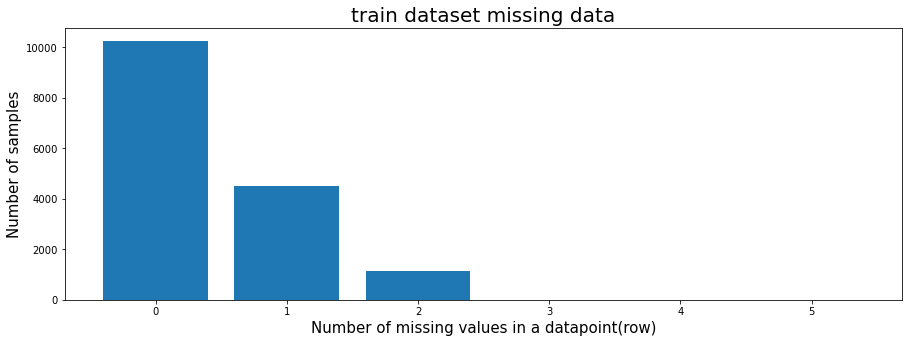

In [4816]:
plt.figure(figsize=(15,5))
plt.bar(*zip(*dict(Counter(train.isnull().sum(axis=1))).items()))
plt.xlabel('Number of missing values in a datapoint(row)', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.title('train dataset missing data', fontsize=20)
plt.show()

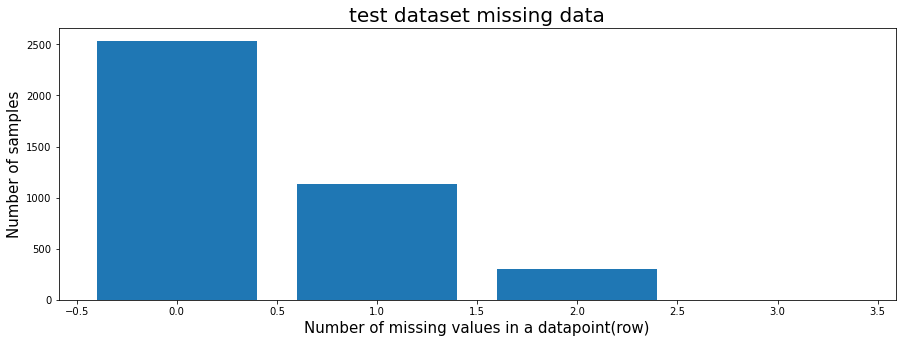

In [4817]:
plt.figure(figsize=(15,5))
plt.bar(*zip(*dict(Counter(test.isnull().sum(axis=1))).items()))
plt.xlabel('Number of missing values in a datapoint(row)', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.title('test dataset missing data', fontsize=20)
plt.show()

`comment:` We can see from above that in most of our data 2 missing features are common followed by one missing feature per row. Most likely `true_cause` and `activity class` as they are the most frequent missing feature. That means that perhaps it is not a good idea to trust in these features for building our model.

#### fillining null data
Since all of the features that contain null values are categorical, we will proceed to change the `NaN` to `unknown`

In [4818]:
# First fill NAN datetime types with neighbor features
fill_datetime_with_neighbors(train)
fill_datetime_with_neighbors(test)

In [4819]:
# Fill remaining object types
train = train.fillna('Unknown')
test = test.fillna('Unknown')

### Feature engineering

As we saw above we have many datetimes in out dataset. However, this will only be usable if we feed them to our model. To achieve this we will need to convert our datetime features to countable features. In this regard I will create new features for year month and day for all each datetime feature.

In [4820]:
# feature engineering
train_feng = datetime_feature_engineering(train)
test_feng = datetime_feature_engineering(test)

In [4821]:
# feature engineering fire_number
train_feng = fire_number_feature_engineering(train_feng)
test_feng = fire_number_feature_engineering(test_feng)

In [4822]:
train_feng.dtypes

fire_number                      object
fire_year                         int64
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
activity_class                   object
true_cause                       object
det_agent_type                   object
det_agent                        object
initial_action_by                object
fire_type                        object
fire_position_on_slope           object
weather_conditions_over_fire     object
fuel_type                        object
fire_duration                   float64
time_to_ex                      float64
time_to_uc                      float64
time_to_bh2                     float64
time_to_bh                      float64
time_to_report                  float64
time_to_assess                  float64
Location                         object
wildfires_in_location             int64


### Standardize data

It is important to standardize data as we don't want our model to skew towards features that have higher values

In [4823]:
# lest visualize non-standard data first
train_feng.describe()

,fire_year,fire_location_latitude,fire_location_longitude,fire_duration,time_to_ex,time_to_uc,time_to_bh2,time_to_bh,time_to_report,time_to_assess,wildfires_in_location
count,15875.000000,15875.000000,15875.000000,1.587500e+04,15875.000000,15875.000000,1.587500e+04,1.587500e+04,15875.000000,1.587500e+04,15875.000000
mean,2011.717228,54.984684,-115.258572,1.600204e+04,4615.530646,703.417134,-1.417583e+04,1.138651e+04,53.954583,1.117855e+04,96.932472
std,3.737510,2.669900,2.300677,4.716082e+05,23732.476442,4835.150244,7.250124e+05,4.709257e+05,2815.397723,4.709270e+05,73.564588
min,2006.000000,49.056267,-119.998067,0.000000e+00,0.000000,0.000000,-4.260241e+07,0.000000e+00,0.000000,-8.886000e+03,1.000000
25%,2008.000000,53.066609,-116.824059,1.950000e+02,22.000000,0.000000,0.000000e+00,7.100000e+01,0.000000,2.300000e+01,39.000000
50%,2012.000000,55.336950,-115.156817,1.055000e+03,164.000000,0.000000,0.000000e+00,1.800000e+02,0.000000,7.700000e+01,81.000000
75%,2015.000000,56.876556,-114.340384,3.760000e+03,1573.000000,96.000000,2.300000e+01,8.950000e+02,2.000000,4.400000e+02,140.000000
max,2018.000000,59.999510,-110.000917,5.863460e+07,598146.000000,186751.000000,6.145600e+04,5.863078e+07,336614.000000,5.863070e+07,408.000000


In [4824]:
# training standarized
numeric_features_indx = np.where(train_feng.dtypes!='O')[0]
numeric_features = train_feng.columns[numeric_features_indx]
standardize = RobustScaler()
train_feng[numeric_features] = standardize.fit_transform(train_feng[numeric_features])
# testing standarized
numeric_features_indx = np.where(test_feng.dtypes!='O')[0]
numeric_features = test_feng.columns[numeric_features_indx]
standardize = RobustScaler()
test_feng[numeric_features] = standardize.fit_transform(test_feng[numeric_features])


In [4825]:
train_feng.describe()

,fire_year,fire_location_latitude,fire_location_longitude,fire_duration,time_to_ex,time_to_uc,time_to_bh2,time_to_bh,time_to_report,time_to_assess,wildfires_in_location
count,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,15875.000000,1.587500e+04,15875.000000,15875.000000,15875.000000,15875.000000
mean,-0.040396,-0.092459,-0.040970,4.192719,2.870104,7.327262,-6.163404e+02,13.600138,26.977291,26.622415,0.157747
std,0.533930,0.700771,0.926319,132.288413,15.301403,50.366148,3.152228e+04,571.511768,1407.698862,1129.321453,0.728362
min,-0.857143,-1.648496,-1.949228,-0.295933,-0.105738,0.000000,-1.852279e+06,-0.218447,0.000000,-21.494005,-0.792079
25%,-0.571429,-0.595898,-0.671280,-0.241234,-0.091554,0.000000,0.000000e+00,-0.132282,0.000000,-0.129496,-0.415842
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,0.428571,0.404102,0.328720,0.758766,0.908446,1.000000,1.000000e+00,0.867718,1.000000,0.870504,0.584158
max,0.857143,1.223786,2.075916,16446.997195,385.546099,1945.322917,2.672000e+03,71153.640777,168307.000000,140601.014388,3.237624


In [4826]:
test_feng.describe()

,fire_year,fire_location_latitude,fire_location_longitude,fire_duration,time_to_ex,time_to_uc,time_to_bh2,time_to_bh,time_to_report,time_to_assess,wildfires_in_location
count,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3969.000000,3.969000e+03,3969.000000,3969.000000,3969.000000,3969.000000
mean,-0.044704,-0.082983,-0.032437,3.035042,2.290948,6.321836,-1.985643e+03,10.599685,9.170446,20.168243,0.169098
std,0.535269,0.681130,0.951642,18.504762,9.587543,58.418068,6.668508e+04,84.132611,148.791520,161.144084,0.743645
min,-0.857143,-1.525187,-2.017126,-0.279456,-0.108808,0.000000,-3.155700e+06,-0.224777,0.000000,-0.183374,-0.790000
25%,-0.571429,-0.589111,-0.675174,-0.227755,-0.093264,0.000000,0.000000e+00,-0.135377,0.000000,-0.127139,-0.410000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,0.428571,0.410889,0.324826,0.772245,0.906736,1.000000,1.000000e+00,0.864623,1.000000,0.872861,0.590000
max,0.857143,1.188782,2.133778,572.299320,191.199482,3052.166667,1.481875e+03,2686.855683,7648.000000,5143.992665,3.250000



### Visualize class distribution
Lets visualize data distribution grouped by class of the target feature after the clean up

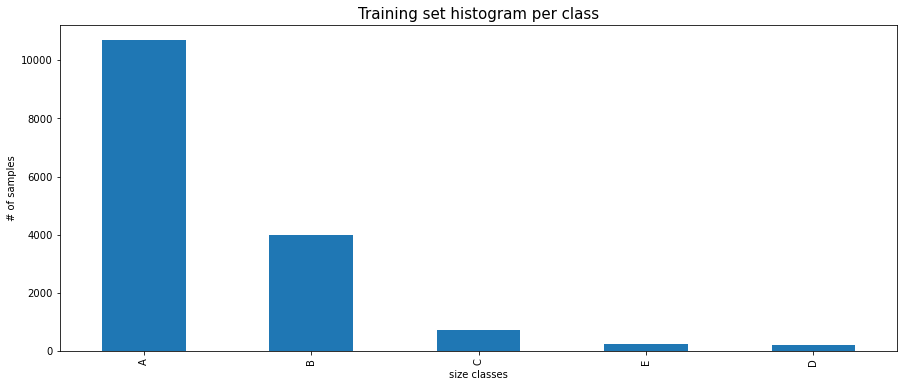

In [4827]:
plt.figure(figsize=(15,6))
train_feng['size_class'].value_counts().plot(kind='bar');
plt.title('Training set histogram per class', fontsize=15);
plt.xlabel('size classes')
plt.ylabel('# of samples');

In [4828]:
train_feng['size_class'].value_counts()

A    10679
B     4000
C      734
E      246
D      216
Name: size_class, dtype: int64

From plot above, we can notice that we have an unbalanced number of classes. Therefore, we must be very cautious to not make our model skew towards the classes with more data

In [1287]:
from sklearn.utils import resample

# Separate majority and minority classes
df_A = train_feng[train_feng.size_class=='A']
df_B = train_feng[train_feng.size_class=='B']
df_C = train_feng[train_feng.size_class=='C']
df_D = train_feng[train_feng.size_class=='D']
df_E = train_feng[train_feng.size_class=='E']

print(len(df_A),len(df_B),len(df_C),len(df_D),len(df_E))


# Upsample minority class
df_B_upsampled = resample(df_B, 
                          replace=True,     # sample with replacement
                          n_samples=10679,    # to match majority class
                          random_state=42) # reproducible results

df_C_upsampled = resample(df_C, 
                          replace=True,     # sample with replacement
                          n_samples=10679,    # to match majority class
                          random_state=42) # reproducible results

df_D_upsampled = resample(df_D, 
                          replace=True,     # sample with replacement
                          n_samples=10679,    # to match majority class
                          random_state=42) # reproducible results

df_E_upsampled = resample(df_E, 
                          replace=True,     # sample with replacement
                          n_samples=10679,    # to match majority class
                          random_state=42) # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_A, df_B_upsampled, df_C_upsampled, df_D_upsampled, df_E_upsampled])
 
# Display new class counts
df_upsampled.size_class.value_counts()


10679 4000 734 216 246


C    10679
D    10679
A    10679
B    10679
E    10679
Name: size_class, dtype: int64

## 2. Build Model

In this section we will build a model to classify `size_class` of our dataset.


### One Hot encode categorical data

In [1288]:
# Extract y_train and X_train
y_train = train_feng[['size_class']]
X_train = train_feng.drop(['size_class', 'fire_number'], 1)
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
# Drop unknown features
Unknown_columns =[column for column in list(X_train_ohe.columns) if 'Unknown' in column]
X_train_ohe.drop(Unknown_columns, 1, inplace=True)
# Standardize categorical data
standardize = RobustScaler()
X_train_ohe[X_train_ohe.columns]=standardize.fit_transform(X_train_ohe)
#_, validation_X, _, validation_y = train_test_split(X_train_ohe, y_train, 
#                                                                test_size=0.35, random_state=2, 
#                                                                stratify=y_train)

In [4829]:
## Only A and B
#indx_A_and_B = (train_feng['size_class']=='E') | (train_feng['size_class']=='D') 
#train_refactored = train_feng[indx_A_and_B]

In [4830]:
# Extract y_train and X_train
y_train = train_feng[['size_class']]
X_train = train_feng.drop(['size_class', 'fire_number'], 1)
# Extract and X_test
X_test = test_feng.drop(['fire_number'], 1)

In [4831]:
# One hot encode data
ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
X_test_ohe = ohe.transform(X_test)

In [4832]:
# Drop unknown features
#Unknown_columns =[column for column in list(X_test_ohe.columns) if 'Unknown' in column]
#X_test_ohe.drop(Unknown_columns, 1, inplace=True)
#X_train_ohe.drop(Unknown_columns, 1, inplace=True)

In [4833]:
# Standardize categorical data
standardize = RobustScaler()
X_test_ohe[X_test_ohe.columns]=standardize.fit_transform(X_test_ohe)
#standardize = RobustScaler()
X_train_ohe[X_train_ohe.columns]=standardize.transform(X_train_ohe)

### Stratified cross validation

We are going to use stratified cross validation to mitigate the imbalance of the dataset that we saw in the EDA section [class distribution](#Visualize-class-distribution) 

In [4834]:
train_X, validation_X, train_y, validation_y = train_test_split(X_train_ohe, y_train, 
                                                                test_size=0.3, random_state=2, 
                                                                stratify=y_train)

### Define feature importance

In all datasets there is always a high chance that some features are irrelevant to predict the target feature. We could try guessing which ones are the most relevant using our intuition. However, intuition is not always good. Therefore, there is an alternative way to do it using feature importances that is available for tree based models in Sklearn. To quickly identify some of the features let's use a simple random forest classifier.

In [1132]:
#model = AdaBoostClassifier(random_state=42)
model = GradientBoostingClassifier(random_state=42, learning_rate=0.5, n_estimators=50, 
                                   max_depth=3)
model.fit(train_X.values, train_y.values.ravel())

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

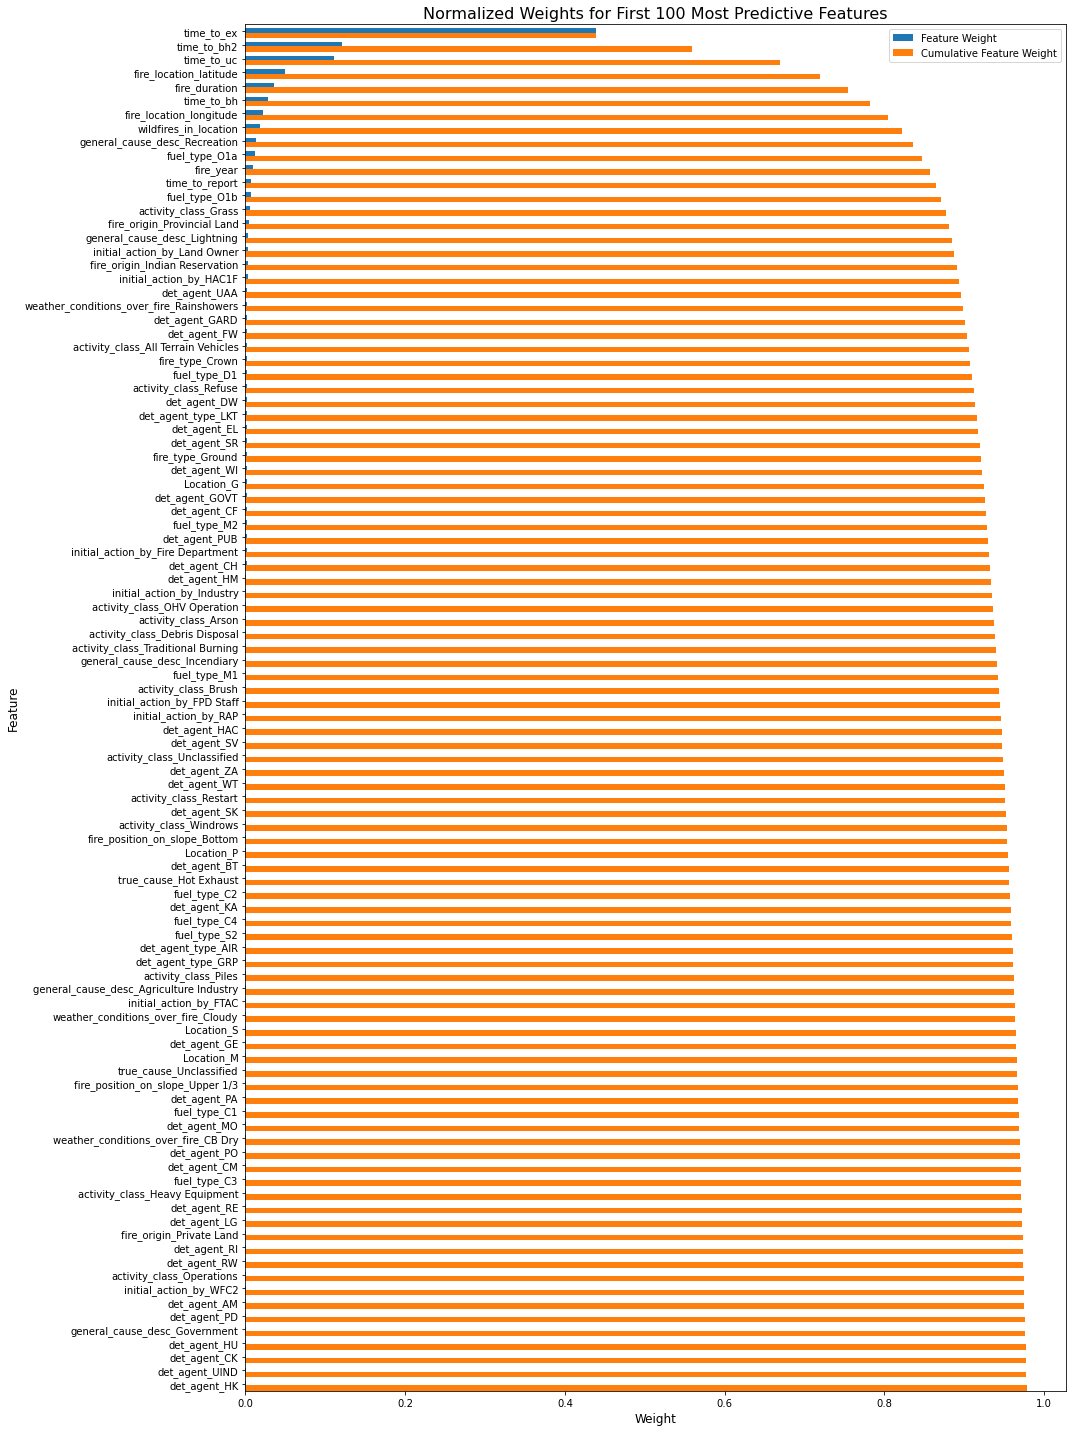

,Features,Importance value
0,time_to_ex,0.438265
1,time_to_bh2,0.120455
2,time_to_uc,0.110536
3,fire_location_latitude,0.049469
4,fire_duration,0.035751
...,...,...
95,general_cause_desc_Government,0.000459
96,det_agent_HU,0.000436
97,det_agent_CK,0.000422
98,det_agent_UIND,0.000415


In [1133]:
relevant_df = feature_plot(importances, train_X, train_y, top_k=100)
relevant_df

We are going to test the model by using only the first features that have more relevance than the remaining ones

In [1134]:
#most_relevant_features = relevant_df[relevant_df['Importance value']>=0.001]['Features']
#most_relevant_features = relevant_df[relevant_df['Importance value']>=0.0015]['Features']
most_relevant_features = relevant_df[relevant_df['Importance value']>=0.002]['Features']
most_relevant_features

0                                   time_to_ex
1                                  time_to_bh2
2                                   time_to_uc
3                       fire_location_latitude
4                                fire_duration
5                                   time_to_bh
6                      fire_location_longitude
7                        wildfires_in_location
8                general_cause_desc_Recreation
9                                fuel_type_O1a
10                                   fire_year
11                              time_to_report
12                               fuel_type_O1b
13                        activity_class_Grass
14                 fire_origin_Provincial Land
15                general_cause_desc_Lightning
16                initial_action_by_Land Owner
17              fire_origin_Indian Reservation
18                     initial_action_by_HAC1F
19                               det_agent_UAA
20    weather_conditions_over_fire_Rainshowers
21           

## PCA

In [3568]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca_train_X = pca.fit_transform(X_train_ohe[:])
pca_test_X = pca.transform(X_test_ohe[:])


In [3569]:
pca_train_X.shape

(15875, 20)

In [3570]:
pca_test_X.shape

(3969, 20)

#### PCA train and validation for splitted data

In [3571]:
pca = PCA(n_components=20)
pca_train_split_X = pca.fit_transform(train_X[:])
pca_validation_split_X =  pca.transform(validation_X[:])
pca_test_X = pca.transform(X_test_ohe[:])

### Balanced models

In [5193]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from time import time
# define model
start = time()

#weights = {'A':1.5, 'B':4, 'C':15, 'D':30, 'E':30}
#weights = {'E': 13, 'D': 8.95240404040404, 'C': 3, 'B': 2, 'A': 1} #32.168 #33.779 #37325
#model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight=weights,
#                              criterion='entropy', max_features=None, min_impurity_decrease=0.003,
#                              n_jobs=-1) 
"""Best model so far"""
#weights = {'A':6, 'B':4, 'C':2.5, 'D':2, 'E':1}
#weights = {'A': 10, 'B': 8, 'C': 3, 'D': 2, 'E': 1} #31.455 test
weights = {'A': 13, 'B': 9, 'C': 3, 'D': 2, 'E': 1} # 32.041 test
weights = {'A': 13, 'B': 8.952631578947368, 'C': 3, 'D': 2, 'E': 1} #32.059
weights = {'A': 13, 'B': 8.952727272727273, 'C': 3, 'D': 2, 'E': 1} #32.162
weights = {'A': 13, 'B': 8.95240404040404, 'C': 3, 'D': 2, 'E': 1} #32.168 #33.779 #37.325
weights = {'A': 13.1717, 'B': 8.9524, 'C': 3, 'D': 2, 'E': 1} #37.528 #37.577
weights = {'A': 12.0, 'B': 7.5, 'C': 3, 'D': 2, 'E': 0.791}
weights = {'A': 12.0, 'B': 7.5, 'C': 3, 'D': 2, 'E': 1}
weights = {'A': 13.1717, 'B': 8.9524, 'C': 3.5, 'D': 3, 'E': 2} #37.528 #37.577
#weights = {'A': 13.2, 'B': 8.95240404040404, 'C': 3.3, 'D': 2, 'E': 1} #32.168 #33.779 #37.325 #38.633 #38.79
#weights = {'A': 11.5, 'B': 8.0, 'C': 3.0, 'D': 2.0, 'E': 1.5}
#weights = {'A': 13.2, 'B': 8.95240404040404, 'C': 3.3, 'D': 2, 'E': 1} #32.168 #33.779 #37.325 #38.633
weights = {'A': 13.2, 'B': 8.95, 'C': 3.31, 'D': 2.0, 'E': 1.2} #32.168 #33.779 #37.325 #38.633 #38.79
model = BalancedRandomForestClassifier(n_estimators=300, max_depth=8,
                                       random_state=42, class_weight=weights,n_jobs = 1,
                                      criterion='entropy', max_features=None, min_impurity_decrease=0.01
                                      , replacement=False,min_samples_leaf = 5, ccp_alpha=0.005, max_leaf_nodes=32,
                                       sampling_strategy= 'auto')

""""""

#model = EasyEnsembleClassifier(base_estimator=GradientBoostingClassifier(random_state=42, learning_rate=0.5, 
#                                                                         n_estimators=100, max_depth=10,
#                                                                        max_features=None), 
#                                n_estimators=10, random_state=42, sampling_strategy= 'all', n_jobs=-1)


#model = EasyEnsembleClassifier(base_estimator=RandomForestClassifier(n_estimators=100, max_depth=10, 
#                                                    class_weight='balanced_subsample', criterion='entropy', 
#                                                    max_features=None, min_impurity_decrease=0.003), 
#                               n_estimators=10, random_state=42, n_jobs=-1)


#model = RUSBoostClassifier(random_state=42,  learning_rate=0.1, n_estimators=300)
#model = RUSBoostClassifier(base_estimator=RandomForestClassifier(class_weight = 'balanced_subsample', max_depth=10,
#                                                                criterion='entropy'),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)

#weights = {'A': 13, 'B': 9.95240404040404, 'C': 4, 'D': 2.8, 'E': 2.2} #32.168 #33.779 #37325
#model2 = RUSBoostClassifier(RandomForestClassifier(random_state=42, n_estimators=100, 
#                                   max_depth=10, class_weight = weights, n_jobs = -1,
#                              criterion='entropy', max_features=None, min_impurity_decrease=0.03),
#                           random_state=42,  learning_rate=0.1, n_estimators=10)

#model = BalancedBaggingClassifier(base_estimator=HistGradientBoostingClassifier(random_state=42, 
#                                        loss='categorical_crossentropy', max_depth=10, min_samples_leaf=5,
#                                       l2_regularization = 0.1, early_stopping=True, scoring='loss',
#                                        learning_rate=0.1, verbose=False, max_leaf_nodes=10), 
#                                  n_estimators=10, random_state=42, n_jobs=1)

#model = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100, max_depth=10, 
#                              class_weight='balanced', criterion='entropy', max_features=None,
#                              min_impurity_decrease=0.003, n_jobs=-1) , 
#            n_estimators=10, random_state=42, n_jobs=1)


# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
metric = make_scorer(geometric_mean_score)
# evaluate model
#scores = cross_val_score(model, pca_train_X, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, X_train_ohe[:], y_train, 
#                         scoring=metric, cv=cv, n_jobs=-1)

scores = cross_val_score(model, X_train_ohe[most_relevant_features], y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
#scores = cross_val_score(model, train_X[most_relevant_features], train_y, scoring='f1_macro', cv=cv, n_jobs=-1)
# summarize performance
end = time()
print(f'Mean f1-score: {np.mean(scores):.5f} time to CV model: {end-start} [s]')

Mean f1-score: 0.59350 time to CV model: 17.01092553138733 [s]


In [3495]:
most_relevant_features=[x for x in most_relevant_features if 'fire_year' not in x]

In [3379]:
most_relevant_features.append('fire_year')

In [3494]:
most_relevant_features=A_B_C_D_E

### Fine tune Hyper parameters

In [4965]:
class_list5

array([0.5 , 0.75, 1.  , 1.25, 1.5 ])

In [4964]:
class_list = np.arange(11,12.1,0.25)
#class_list2 = np.linspace(3,5,100)
class_list2 = np.arange(8.0,9.1,0.25)
class_list3 = np.arange(3.0,4.1,0.25)
class_list4 = np.arange(1.5,2.51,0.25)
class_list5 = np.arange(0.5,1.51,0.25)

print(
    f"total time: {8/3600*(len(class_list)*len(class_list2)*len(class_list3)*len(class_list4)*len(class_list5))}[h]")

total time: 6.944444444444445[h]


In [4968]:
list_of_weights = {'A':class_list, 'B':class_list2, 'C':class_list3, 'D':class_list4, 'E':class_list5}
best_score = 0.0
for A_value in list_of_weights['A']:
    for B_value in list_of_weights['B']:
        for C_value in list_of_weights['C']:
            for D_value in list_of_weights['D']:
                for E_value in list_of_weights['E']:
                    weights = {'A':A_value, 'B':B_value, 'C':C_value, 'D':D_value, 'E':E_value}
                    model = BalancedRandomForestClassifier(n_estimators=100, max_depth=8,
                                       random_state=42, class_weight=weights,n_jobs = 1,
                                      criterion='entropy', max_features=None, min_impurity_decrease=0.01
                                      , replacement=False,min_samples_leaf = 5, ccp_alpha=0.005, max_leaf_nodes=32,
                                       sampling_strategy= 'auto')
                    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
                    scores = cross_val_score(model, X_train_ohe[most_relevant_features]
                                             , y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
                    final_score = np.mean(scores)
                    print(f"Current score: {final_score}, Current weights: {weights}", end="\r", flush=True)
                    if final_score > best_score:
                        best_score = final_score
                        best_weighs = weights
                        print(f"Best score: {best_score}, Best weights: {best_weighs}\n")

Best score: 0.5604807645727832, Best weights: {'A': 11.0, 'B': 8.0, 'C': 3.0, 'D': 1.5, 'E': 0.5}: 0.5}

Best score: 0.589188110160053, Best weights: {'A': 11.0, 'B': 8.0, 'C': 3.0, 'D': 1.5, 'E': 0.75} 0.75}

Best score: 0.589979361256564, Best weights: {'A': 11.0, 'B': 8.0, 'C': 3.0, 'D': 1.5, 'E': 1.25} 1.25}

Best score: 0.5927854882831517, Best weights: {'A': 11.0, 'B': 8.0, 'C': 3.0, 'D': 1.75, 'E': 1.5}: 1.5}}

Best score: 0.5928413468847911, Best weights: {'A': 11.0, 'B': 8.0, 'C': 3.25, 'D': 1.75, 'E': 1.5}: 1.5}}

Best score: 0.5939441482753255, Best weights: {'A': 11.0, 'B': 8.0, 'C': 3.5, 'D': 2.0, 'E': 1.5}: 1.5}}}}

Best score: 0.5949158154761639, Best weights: {'A': 11.0, 'B': 8.0, 'C': 4.0, 'D': 2.25, 'E': 1.5}: 1.5}}}

Best score: 0.5954404911292459, Best weights: {'A': 11.75, 'B': 8.0, 'C': 3.25, 'D': 1.75, 'E': 1.5}: 1.5}}}



### Train Validation results

In [2383]:
train_X, validation_X, train_y, validation_y = train_test_split(X_train_ohe, y_train, 
                                                                test_size=0.3, random_state=3126, 
                                                                stratify=y_train)

In [5134]:
#model.fit(pca_train_split_X, train_y.values.ravel())
model.fit(train_X[most_relevant_features], train_y.values.ravel())
#model.fit(X_train_ohe, y_train.values.ravel())

#pred_validation_y = model.predict(pca_validation_split_X)
pred_validation_y = model.predict(validation_X[most_relevant_features])
#pred_y = model.predict(X_train_ohe)
f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(validation_y.values.ravel(), pred_validation_y)
gmean_score_sparse = geometric_mean_score(validation_y.values.ravel(), pred_validation_y, average=None)
print(f"F1-score - validation:{f1_score}")
print(f"Geometric mean - validation:{gmean_score}")
print(f"Geometric mean per class - validation:{gmean_score_sparse}")

print("-------------------------------------------------------------------------------------------")
#pred_train_y = model.predict(pca_train_split_X)
pred_train_y = model.predict(train_X[most_relevant_features])
f1_score = fbeta_score(train_y.values.ravel(), pred_train_y, beta = 1, average='macro')
gmean_score = geometric_mean_score(train_y.values.ravel(), pred_train_y)
gmean_score_sparse = geometric_mean_score(train_y.values.ravel(), pred_train_y, average=None)
print(f"F1-score - train:{f1_score}")
print(f"Geometric mean - train:{gmean_score}")
print(f"Geometric mean per class - train:{gmean_score_sparse}")

F1-score - validation:0.5802069796596063
Geometric mean - validation:0.5736292466050498
Geometric mean per class - validation:[0.80701734 0.74286515 0.65068935 0.66323905 0.76098508]
-------------------------------------------------------------------------------------------
F1-score - train:0.6274648006864698
Geometric mean - train:0.6402342492457319
Geometric mean per class - train:[0.81132447 0.74152935 0.69254277 0.78383356 0.79875839]


In [2306]:
best_score=0.0
for i in list(range(20000)):
    train_X, validation_X, train_y, validation_y = train_test_split(X_train_ohe, y_train, 
                                                                test_size=0.3, random_state=i, 
                                                                stratify=y_train)
    #model.fit(pca_train_split_X, train_y.values.ravel())
    model.fit(train_X[most_relevant_features], train_y.values.ravel())
    #model.fit(X_train_ohe, y_train.values.ravel())

    pred_validation_y = model.predict(validation_X[most_relevant_features])
    f1_score = fbeta_score(validation_y.values.ravel(), pred_validation_y, beta = 1, average='macro')
    
    print(f"Current f1-score: {f1_score}, Current random_state: {i}", end="\r", flush=True)
    if f1_score > best_score:
        best_score = f1_score
        best_weighs = i
        print(f"Best score: {best_score}, Best random_state: {best_weighs}\n")

Best score: 0.5733747738913346, Best random_state: 0_state: 0

Best score: 0.5958333453604795, Best random_state: 2_state: 2

Best score: 0.6132595262484275, Best random_state: 7_state: 7

Best score: 0.6143779557023636, Best random_state: 16state: 16

Best score: 0.6191984798373141, Best random_state: 24state: 24

Best score: 0.6203086500046952, Best random_state: 30state: 30

Best score: 0.6222518130435966, Best random_state: 125tate: 125

Best score: 0.6263135426988413, Best random_state: 220tate: 220

Best score: 0.63549790794399, Best random_state: 452tate: 45251

Best score: 0.6365441130576862, Best random_state: 758tate: 758

Best score: 0.6369833207524922, Best random_state: 915tate: 915

Best score: 0.6375624630924264, Best random_state: 3126ate: 3126

Best score: 0.6391785620233101, Best random_state: 6194ate: 6194

Best score: 0.6429016944470809, Best random_state: 9003ate: 9003

Best score: 0.6437582915889312, Best random_state: 14964te: 14964

Best score: 0.649985133487720

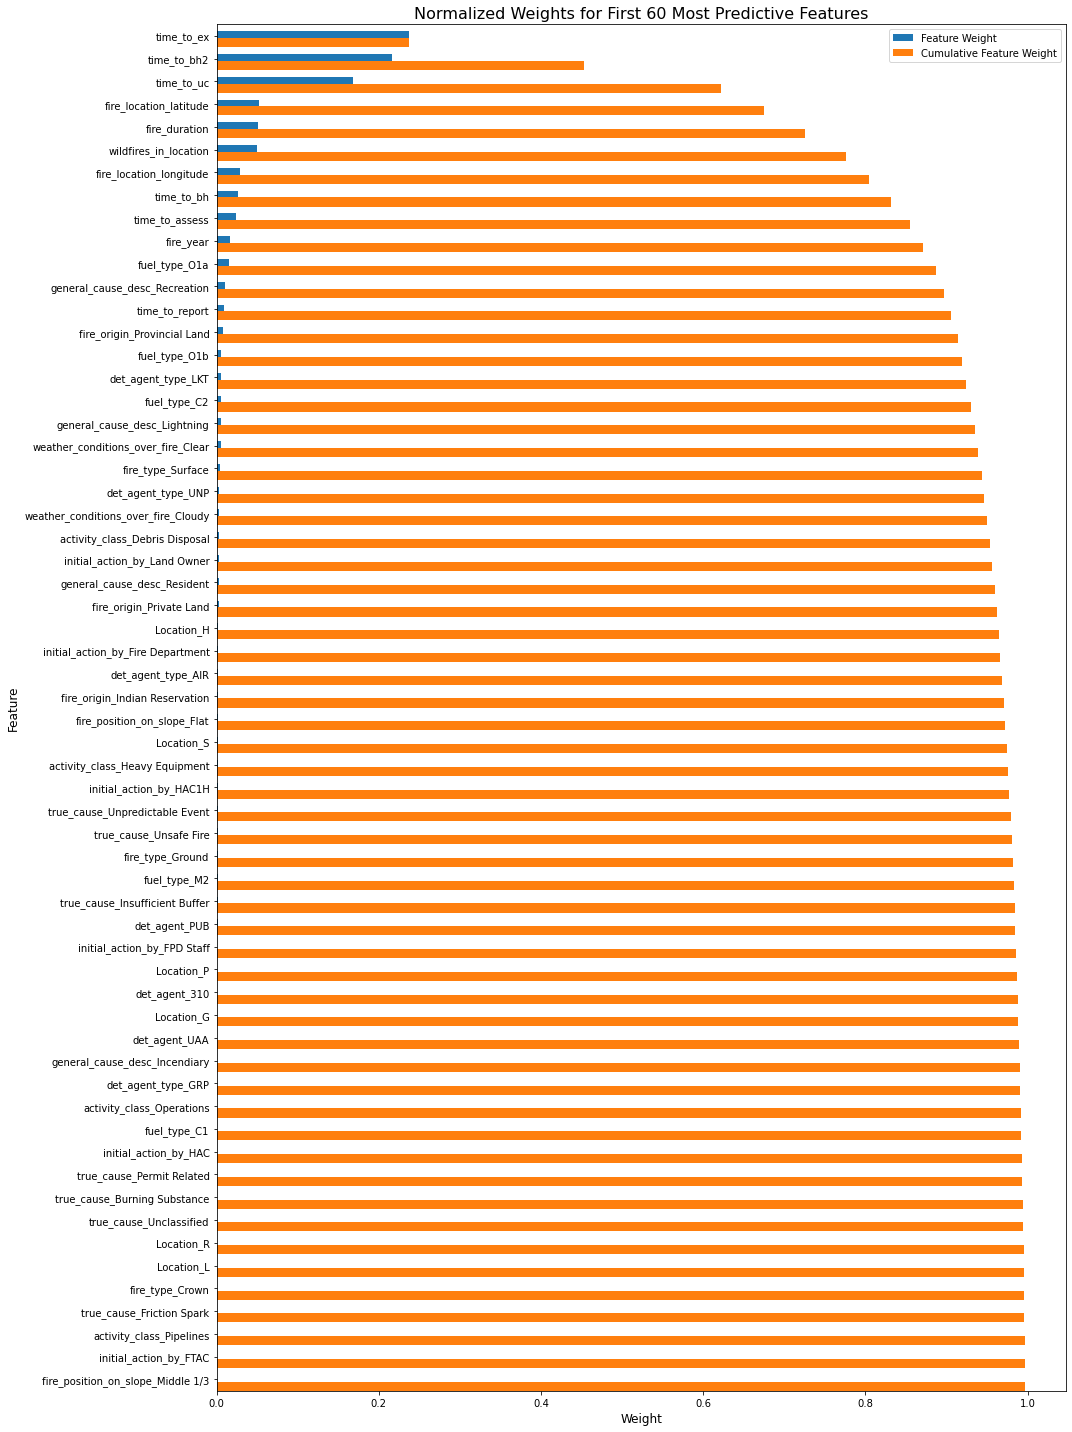

,Features,Importance value
0,time_to_ex,0.237016
1,time_to_bh2,0.216305
2,time_to_uc,0.168689
3,fire_location_latitude,0.052852
4,fire_duration,0.051199
5,wildfires_in_location,0.049450
6,fire_location_longitude,0.028845
7,time_to_bh,0.026740
8,time_to_assess,0.024084
9,fire_year,0.016206


In [4835]:
# Extract the feature importances using .feature_importances_ 
model2 = BalancedRandomForestClassifier(n_estimators=100, max_depth=10,
                                       random_state=42, class_weight=weights,n_jobs = 1,
                                      criterion='entropy', max_features=None, min_impurity_decrease=0.005
                                      ,min_samples_leaf = 5, ccp_alpha=0.008, max_leaf_nodes=None,
                                       sampling_strategy= 'auto')
model2.fit(train_X[:], train_y.values.ravel())
importances = model2.feature_importances_
relevant_df = feature_plot(importances, train_X[:], train_y, top_k=60)
indx = relevant_df['Importance value']>=0.002
display(relevant_df[indx])
most_relevant_features = relevant_df[indx]['Features']


In [2153]:
A_B_C_D_E = list(a_b_c_d)+list(D_E-a_b_c_d)

In [2162]:
A_B_C_D_E

['fire_origin_Provincial Land',
 'time_to_bh2',
 'wildfires_in_location',
 'activity_class_Operations',
 'initial_action_by_FPD Staff',
 'det_agent_type_LKT',
 'Location_S',
 'fire_location_longitude',
 'fire_type_Ground',
 'det_agent_GOVT',
 'weather_conditions_over_fire_Cloudy',
 'activity_class_Grass',
 'general_cause_desc_Recreation',
 'true_cause_Permit Related',
 'Location_G',
 'initial_action_by_HAC1H',
 'general_cause_desc_Resident',
 'fuel_type_O1a',
 'fire_duration',
 'det_agent_type_AIR',
 'general_cause_desc_Lightning',
 'true_cause_Hot Exhaust',
 'Location_H',
 'det_agent_type_UNP',
 'initial_action_by_Land Owner',
 'fire_location_latitude',
 'fire_position_on_slope_Flat',
 'weather_conditions_over_fire_Clear',
 'true_cause_Burning Substance',
 'fuel_type_O1b',
 'fire_type_Crown',
 'fuel_type_C2',
 'time_to_report',
 'det_agent_type_GRP',
 'time_to_uc',
 'time_to_bh',
 'true_cause_Friction Spark',
 'activity_class_Unclassified',
 'fire_origin_Private Land',
 'fuel_type_M2'

In [4988]:
y_valid_pred = pd.DataFrame()
y_valid_pred['fire_number'] = train_feng['fire_number']
y_valid_pred['size_class'] = model.predict(X_train_ohe[most_relevant_features])
#y_valid_pred['size_class'] = model.predict(pca_train_X)
y_valid_pred['size_class'].hist()
y_valid_pred['size_class'].value_counts()

NotFittedError: This BalancedRandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

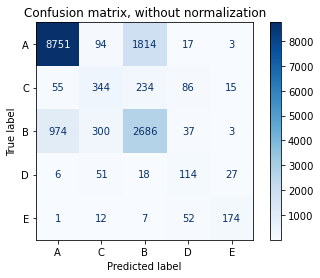

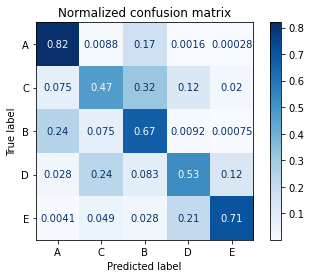

In [5194]:
from sklearn.metrics import plot_confusion_matrix

model.fit(train_X[most_relevant_features], train_y.values.ravel())

class_names = validation_y['size_class'].unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
#validation_X[most_relevant_features]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_train_ohe[most_relevant_features], y_train.values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

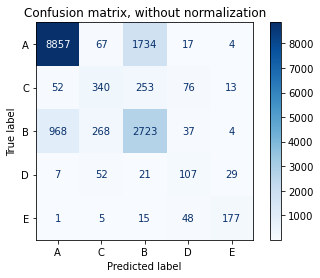

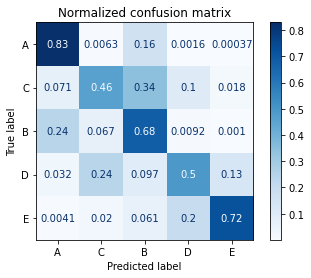

In [5184]:
from sklearn.metrics import plot_confusion_matrix

model.fit(X_train_ohe[most_relevant_features], y_train.values.ravel())

class_names = validation_y['size_class'].unique()

# Plot non-normalized and normalized confusion matrices
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
#validation_X[most_relevant_features]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_train_ohe[most_relevant_features], y_train.values.ravel(),
                                 labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

### Deep Neural Network
[refence](https://machinelearningmastery.com/cost-sensitive-neural-network-for-imbalanced-classification/)

In [331]:
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, InputLayer, GlobalAveragePooling1D
from keras.models import Sequential
from keras.optimizers import Adam


# define the neural network model
def define_NN_model(n_input):
    ## Hyperparameters
    lr = 1e-3
    dropout_prob = 0.1
    
    # define model
    model = Sequential(name='Wildfire model')
    model.add(InputLayer(input_shape=(n_input,1)))
    model.add(Conv1D(filters=10000, kernel_size=10, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling1D())
    #model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='softmax'))
    
    # define loss and optimizer
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
    return model

In [332]:
# One hot encode for the labels
ohe = ce.OneHotEncoder(use_cat_names=True)
y_train_ohe = ohe.fit_transform(train_y)
y_validation_ohe = ohe.transform(validation_y)

y_validation_ohe.sample(1)

,size_class_A,size_class_B,size_class_C,size_class_E,size_class_D
8204,1,0,0,0,0


In [333]:
#input_size = train_X[:].shape[1]
input_size = pca_train_split_X.shape[1]
model = define_NN_model(input_size)
model.summary()

Model: "Wildfire model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 8, 10000)          110000    
_________________________________________________________________
batch_normalization_83 (Batc (None, 8, 10000)          40000     
_________________________________________________________________
global_average_pooling1d_6 ( (None, 10000)             0         
_________________________________________________________________
dense_132 (Dense)            (None, 100)               1000100   
_________________________________________________________________
batch_normalization_84 (Batc (None, 100)               400       
_________________________________________________________________
dense_133 (Dense)            (None, 5)                 505       
Total params: 1,151,005
Trainable params: 1,130,805
Non-trainable params: 20,200
_____________________________________

In [334]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Callbacks definitions
early = EarlyStopping(monitor='val_loss', 
                       mode= 'min', 
                       patience=2)
lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=0, verbose=2, mode='min')

roc = RocCallback(training_data=(pca_train_split_X, y_train_ohe),
                  validation_data=(pca_validation_split_X, y_validation_ohe))

f1_macro=F1Callback(training_data=(pca_train_split_X, y_train_ohe),
                  validation_data=(pca_validation_split_X, y_validation_ohe))

callbacks_list = [lr_reduce, early, f1_macro]



## Run model {A, B, C, E, D}
#weights = {0:1, 1:2.7, 2:14.5, 3:43.5, 4:50}
#weights = {0:1, 1:4.7, 2:14, 3:43, 4:50}
weights = {3: 13, 4: 8.95240404040404, 2: 3, 1: 2, 0: 1}
#weights = {0:2, 1:2, 2:1, 3:1, 4:1}
"""
model.fit(train_X[:], y_train_ohe, 
          validation_data=(validation_X[:], y_validation_ohe),
          epochs=100, verbose=1, class_weight=weights,
         callbacks=callbacks_list)
"""

model.fit(pca_train_split_X.reshape(-1,8,1), y_train_ohe, 
          validation_data=(pca_validation_split_X.reshape(-1,8,1), y_validation_ohe),
          epochs=100, verbose=1, class_weight=weights,
         callbacks=callbacks_list, batch_size=128)


Train on 11112 samples, validate on 4763 samples
Epoch 1/100
11112/11112 [==============================] - 35s 3ms/step - loss: 2.2465 - accuracy: 0.6586 - val_loss: 1.7439 - val_accuracy: 0.0157
f1_macro_train: 0.0346 - f1_macro_val: 0.0286                                                                                                    
Epoch 2/100
11112/11112 [==============================] - 34s 3ms/step - loss: 1.7229 - accuracy: 0.6907 - val_loss: 1.5128 - val_accuracy: 0.6378
f1_macro_train: 0.0318 - f1_macro_val: 0.025                                                                                                    
Epoch 3/100
11112/11112 [==============================] - 34s 3ms/step - loss: 1.5734 - accuracy: 0.6908 - val_loss: 1.2547 - val_accuracy: 0.6805
f1_macro_train: 0.0631 - f1_macro_val: 0.0468                                                                                                    
Epoch 4/100
 7296/11112 [==================>...........] - ETA: 10s - 

KeyboardInterrupt: 

F1-score - validation:0.8328205302760298


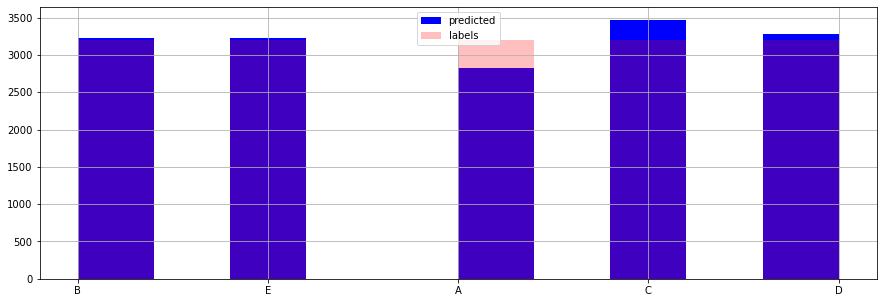

In [214]:
y_valid_pred = pd.DataFrame()
y_valid_pred['labels'] = validation_y.values.ravel()
y_valid_pred['size_class'] = oneHotEnc_to_classes(model.predict(pca_validation_split_X.reshape(-1,8,1)), 
                                                  y_validation_ohe.columns)
                                          

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)    
#y_valid_pred['size_class'] = model.predict(pca_train_X)
y_valid_pred['size_class'].hist(ax=ax, color='b')
y_valid_pred['labels'].hist(ax=ax, alpha = 0.25,  color= 'r')
ax.legend(['predicted', 'labels'])

f1_score = fbeta_score(y_valid_pred['labels'], y_valid_pred['size_class'], beta = 1, average='macro')
print(f"F1-score - validation:{f1_score}")


Legitimate Transactions Detected (True Negatives):  0.632334581772784
Legitimate Transactions Incorrectly Detected (False Positives):  0.0024968789013732834
Fraudulent Transactions Missed (False Negatives):  0.0
Fraudulent Transactions Detected (True Positives):  0.9965667915106118
Total Fraudulent Transactions:  1.0


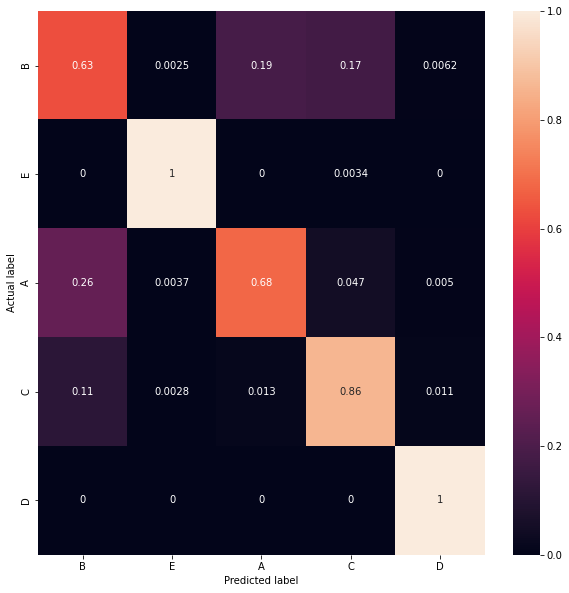

In [215]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_cm(labels, predictions):
    class_names_pred = predictions.unique()
    class_names_labels = labels.unique()
    cm = confusion_matrix(labels, predictions, normalize='true', labels=class_names_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, xticklabels=class_names_pred, yticklabels=class_names_pred)#, fmt="d")
    #plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
plot_cm(y_valid_pred['labels'], y_valid_pred['size_class'])

#### Optimize model

In [544]:
# Initialize the classifier
model = GradientBoostingClassifier(random_state=42, max_depth=3)

# Create the parameters to tune
parameters = {  
    'n_estimators': [500],
    'learning_rate': [0.01]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1.0, average='macro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(model, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(train_X[most_relevant_features].values, train_y.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the optimized model
best_predictions_validation = best_clf.predict(validation_X[most_relevant_features])
best_predictions_train = best_clf.predict(train_X[most_relevant_features])

# Report the before-and-afterscores
print("Optimized model\n------")
print("F-score on validation data: {:.4f}".format(fbeta_score(validation_y.values.ravel(), 
                                                              best_predictions_validation, 
                                                              beta = 1.0, average='macro')))

print("F-score on training data: {:.4f}".format(fbeta_score(train_y.values.ravel(), 
                                                            best_predictions_train, 
                                                            beta = 1.0, average='macro')))

Optimized model
------
F-score on validation data: 0.3184
F-score on training data: 0.4649


In [ ]:
# Initialize the classifier
model = BalancedRandomForestClassifier(n_estimators=100, max_depth=10,
                                       random_state=42, n_jobs = 1,
                                      criterion='entropy', max_features=None, min_impurity_decrease=0.003
                                      ,min_samples_leaf = 5, ccp_alpha=0.008, sampling_strategy= 'all')
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scores = cross_val_score(model, pca_train_X, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
final_score = np.mean(scores)

# Create the parameters to tune
parameters = {  
    'class_weight': [{'A':[1,3,4], 'B':7, 'C':7, 'D':2, 'E':1}]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=1.0, average='macro')

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(model, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(train_X[most_relevant_features].values, train_y.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the optimized model
best_predictions_validation = best_clf.predict(validation_X[most_relevant_features])
best_predictions_train = best_clf.predict(train_X[most_relevant_features])

# Report the before-and-afterscores
print("Optimized model\n------")
print("F-score on validation data: {:.4f}".format(fbeta_score(validation_y.values.ravel(), 
                                                              best_predictions_validation, 
                                                              beta = 1.0, average='macro')))

print("F-score on training data: {:.4f}".format(fbeta_score(train_y.values.ravel(), 
                                                            best_predictions_train, 
                                                            beta = 1.0, average='macro')))

In [545]:
best_clf

GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,
                           random_state=42)

## 3. Make submission

In [5195]:
y_test_pred = pd.DataFrame()
y_test_pred['fire_number'] = test_feng['fire_number']
#y_test_pred['size_class'] = model.predict(pca_test_X)
#y_test_pred['size_class'] = oneHotEnc_to_classes(model.predict(pca_test_X.reshape(-1,8,1)), 
#                                                 y_validation_ohe.columns)
y_test_pred['size_class'] = model.predict(X_test_ohe[most_relevant_features])

In [5196]:
freeze_A = y_test_pred['size_class']=='A'
freeze_B = y_test_pred['size_class']=='B'
freeze_C = y_test_pred['size_class']=='C'
freeze_D = y_test_pred['size_class']=='D'
freeze_E = y_test_pred['size_class']=='E'
freeze_ind = ~freeze_A & ~freeze_D & ~freeze_E

In [5197]:
len(X_test_ohe[most_relevant_features][freeze_ind])

1377

In [5198]:
## llenar no freezeados
y_test_pred['fire_number'][freeze_ind] = test_feng['fire_number'][freeze_ind]
#y_test_pred['size_class'] = model.predict(pca_test_X)
#y_test_pred['size_class'] = oneHotEnc_to_classes(model.predict(pca_test_X.reshape(-1,8,1)), 
#                                                 y_validation_ohe.columns)
y_test_pred['size_class'][freeze_ind] = model.predict(X_test_ohe[most_relevant_features][freeze_ind])

A    2480
B    1174
C     203
D      70
E      42
Name: size_class, dtype: int64

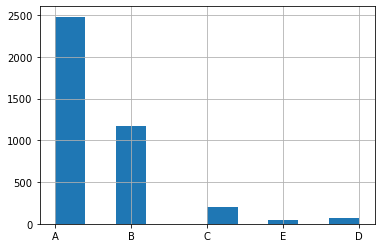

In [5199]:
#new
y_test_pred['size_class'].hist()
y_test_pred['size_class'].value_counts()

A    2480
B    1174
C     203
D      70
E      42
Name: size_class, dtype: int64

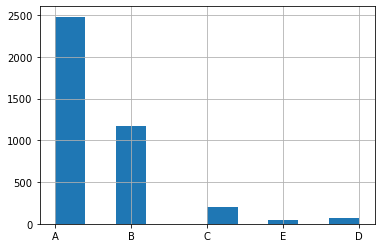

In [5200]:
# Best so far
y_test_pred['size_class'].hist()
y_test_pred['size_class'].value_counts()

In [4979]:
print(y_test_pred.shape)

(3969, 2)


### Push the prediction to CARINO platform

[Parameters](#Balanced-models)


In [5201]:
import math
import requests

TOKEN = 'bef13dde60939ab809582f85a2518337f4eee028e2ea385cf64831961737072d977ed884b5c4e58821b1e5f1f5376aa2f6afecacab61ea9ecf406c89cc1e19cf' # Replace with 'your token' (please ensure value is between quotes)
comment = 'some comment' # Free text, visible by you only


def submit_prediction(df, TOKEN=None, sep=',', comment='', compression='gzip', **kwargs):
    if TOKEN is None:
        print("Please set TOKEN to the value provided in CARINO plarform under Submissions tab")
        return None
    URL='http://18.185.86.47/api/submissions'
    df.to_csv('temporary.dat', sep=sep, compression=compression, **kwargs)
    r = requests.post(URL, headers={'Authorization': 'Bearer {}'.format(TOKEN)},files={'datafile': open('temporary.dat', 'rb')},data={'comment':comment, 'compression': compression})
    if r.status_code == 429:
        raise Exception('Submissions are too close. Next submission is only allowed in {} minutes.'.format(int(math.ceil(int(r.headers['x-rate-limit-remaining']) / 1000.0 / 60.0))))
    if r.status_code != 200:
        raise Exception(r.text)

In [5202]:
submit_prediction(y_test_pred, TOKEN, sep=',', index=True, comment=comment)

## 4. References

* [Stratified cross validation](https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/)
* [Oversampling using SMOTE](https://medium.com/lumiata/cross-validation-for-imbalanced-datasets-9d203ba47e8)

In [4199]:
A = [2483,2476,2476,2490,2479,2483,2479,2481,2469,2498,2609,2515,2511,2500,2511,2498,2507,2506,2482,2505,2497,2501,
    2500, 2499,2500,2499,2500,2505,2501,2495,2490,2501,2500,2505,2492,2493,2494,2501]
B = [1180,1182,1175,1159,1179,1177,1177,1172,1187,1157,1070,1141,1140,1155,1139,1154,1148,1153,1133,1147,1159,1154,
    1158, 1162,1159,1161,1154,1150,1154,1163,1163,1159,1158,1154,1165,1161,1161,1157]
C = [199,205,211,210,204,202,207,210,207,207,182,205,207,206,209,206,206,199,234,206,204,207,204,200,203,201,207,
     205,206,204,210,197,204,203,205,208,206,203]
D = [70,69,69,75,70,70,68,68,69,69,72,70,71,69,72,72,70,72,90,72,70,69,69,69,69,69,70,70,69,69,69,73,69,69,69,69,70,
    70]
E = [37,37,38,35,37,37,38,38,37,38,36,38,40,39,38,39,38,39,30,39,39,39,38,39,38,39,38,39,39,38,39,39,38,38,38,38,38,
    38]
target = np.array([38.843,39.091,38.764,38.79,38.69,38.938,39.144,39.122,39.022,39.315,
                   38.820,38.591,38.164,39.385,38.291,38.343,39.088,38.98,35.87,38.603,
                  39.234,39.302,39.332,38.973,39.365,38.99,39.320,38.90,39.094,39.363,
                  39.181,38.65,39.313,39.243,39.228,39.139,39.314,39.365]).reshape(-1,1)
comments = np.array(['-','-','-','-','-','-','-','-','-','-','-','-','-','-','-','-','A_B_C_D_E',
                    'RUS for feature importance','PCA 100','feature impt 0.001','feature impt 0.002',
                    'min_impurity 0.009', 'min_impurity 0.01', 'feature_imp 0.0025','feature impt model 0.002',
                    'feature impt model 0.0025', 'feature impt model 0.0015', 'feature impt model 0.0001',
                    'feature impt model 0.0006', 'feature impt model 0.0023','C+0.1','C-0.1','C-0.01','B+0.01',
                    'A+0.1717 B+0.0024','B+0.0024','B+0.0024 C-0.01','C+0.001'])
df = pd.DataFrame({'A':A, 'B':B, 'C':C, 'D':D, 'E':E})
df['score']=target
df['comments']=comments

In [4200]:
df.sort_values('score', ascending=False)

,A,B,C,D,E,score,comments
13,2500,1155,206,69,39,39.385,-
24,2500,1159,203,69,38,39.365,feature impt model 0.002
37,2501,1157,203,70,38,39.365,C+0.001
29,2495,1163,204,69,38,39.363,feature impt model 0.0023
22,2500,1158,204,69,38,39.332,min_impurity 0.01
26,2500,1154,207,70,38,39.320,feature impt model 0.0015
9,2498,1157,207,69,38,39.315,-
36,2494,1161,206,70,38,39.314,B+0.0024 C-0.01
32,2500,1158,204,69,38,39.313,C-0.01
21,2501,1154,207,69,39,39.302,min_impurity 0.009
